# Vertica `TIMESERIES` 
> "Provides gap-filling and interpolation (GFI) computation, an important component of time series analytics computation."

## Syntax: 
```
TIMESERIES slice_time AS 'length_and_time_unit_expression' OVER ( 
... [ window_partition_clause  [ , ... ] ]  
... ORDER BY time_expression ) 
... [ ORDER BY table_column [ , ... ] ]
```

## 1. Connect to the Database
(be sure you have a running Vertica database at `localhost:5433`)

In [26]:
import vertica_python
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'



connection_params = {
    'host' : 'localhost',
    'port' : 5433,
    'database' : 'docker',
    'user' : 'dbadmin',
    'password' : ""
}

connection = vertica_python.connect(**connection_params)
cur = connection.cursor()


## 2. Load the Data into Vertica
We're loading a dataset of mallard duck GPS location tracks from a several-month period. The data is accessible from [this link](https://s3-us-west-2.amazonaws.com/cse599c-sp17/mallard.csv). We'll download it here: 

In [3]:
%%bash 
curl -O https://s3-us-west-2.amazonaws.com/cse599c-sp17/mallard.csv
ls mallard.csv

mallard.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 8479k  100 8479k    0     0  8417k      0  0:00:01  0:00:01 --:--:-- 8470k


I've already written a schema for this file, let's look at it:


In [4]:
%%bash 
more createMallardsTable.sql

create table if not exists mallards (
	eventId varchar(20) PRIMARY KEY,
	ts timestamp,
	locationLong float,
	locationLat float);



We'll run the schema and load the data from the downloaded file.

In [5]:
tablefile = "createMallardsTable.sql"
with open(tablefile,'r') as createTable:
    cur.execute(createTable.read())
    
mallardfile = "mallard.csv"

cur = connection.cursor()
with open(mallardfile, "rb") as f:
    cur.copy("COPY mallards from stdin PARSER fcsvparser()", f)

And test it out: 

In [24]:
cur.execute("select count(*) from mallards limit 10")
print(cur.fetchall())

[[161451]]


## 2. Develop some `TIMESERIES` Queries

### Primitives:
* `ts_first_value(<column>, '{'const', 'linear'}')` : provides the first value in a timeslice for a given column using the given interpolation strategy.
* `ts_last_value(<column>, '{'const', 'linear}')`: same as above but with last value. 

In [15]:
cur.execute(
    "select slice_time, ts_first_value(locationLong, 'const'), ts_first_value(locationLat, 'const')\
    from mallards\
    where ts between timestamp '2012-08-24 10:00' and timestamp '2012-08-24 17:00'\
    TIMESERIES slice_time AS '2 minutes' OVER (ORDER BY ts);"
)
df_const = pd.DataFrame(cur.fetchall())
df_const.head(3)


,0,1,2
0,2012-08-24 10:04:00,NaN,NaN
1,2012-08-24 10:06:00,4.724853,51.878796
2,2012-08-24 10:08:00,4.723606,51.876247


It works!

In [17]:
cur.execute(
    "select slice_time, ts_first_value(locationLong, 'linear'), ts_first_value(locationLat, 'linear')\
    from mallards\
    where ts between timestamp '2012-08-24 10:00' and timestamp '2012-08-24 17:00'\
    TIMESERIES slice_time AS '2 minutes' OVER (ORDER BY ts);"
)
df_linear = pd.DataFrame(cur.fetchall())
df_linear.head(3)

,0,1,2
0,2012-08-24 10:04:00,NaN,NaN
1,2012-08-24 10:06:00,4.719763,51.878265
2,2012-08-24 10:08:00,4.724086,51.876621


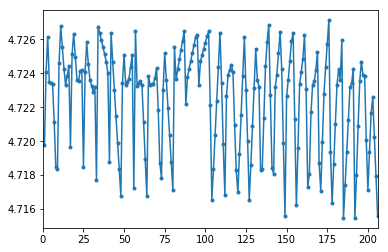

In [19]:
df_linear[1].plot(marker=".")


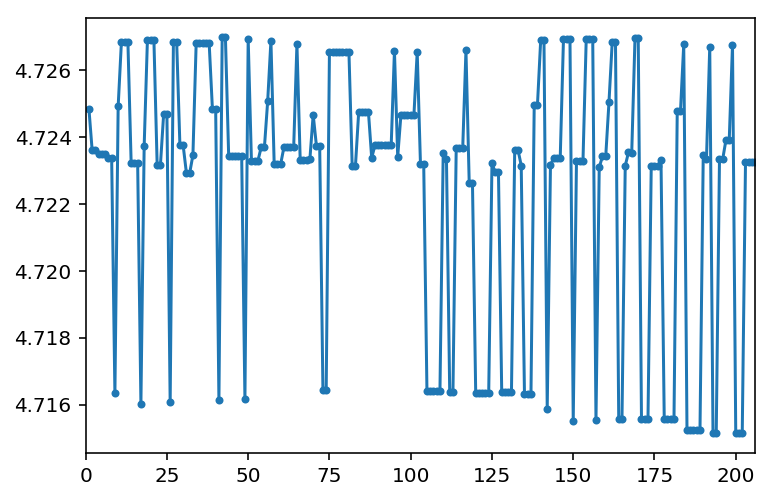

In [28]:
df_const[1].plot(marker=".")

In [21]:
df_const[1].plot

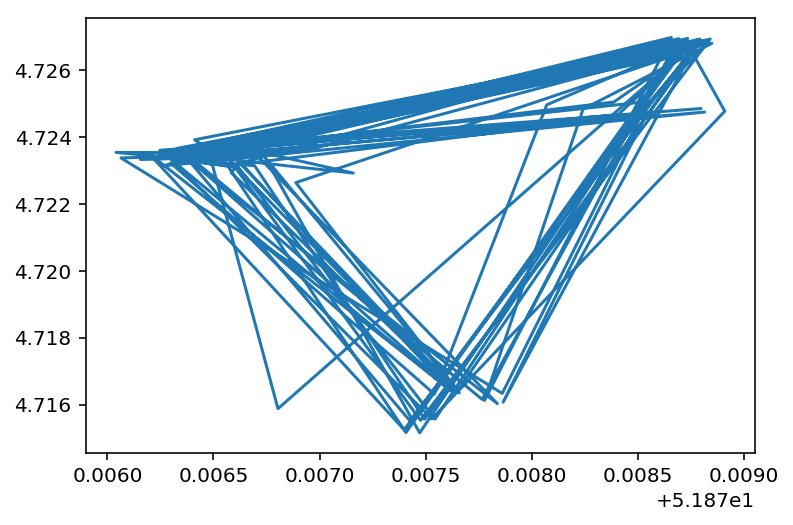

In [27]:
plt.plot(df_const[2], df_const[1])

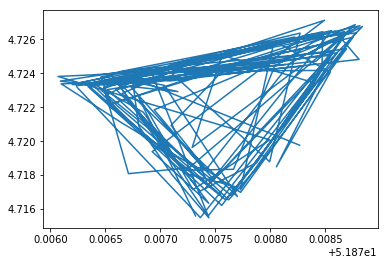

In [23]:
plt.plot(df_linear[2], df_linear[1])